In [1]:
import numpy as np
import math
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import LearningRateScheduler


Using TensorFlow backend.


# **Importing data**

In [36]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"","key":""}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
!kaggle datasets download -d xabdallahali/plantvillage-dataset/color -p /content


 99% 2.02G/2.04G [00:44<00:00, 30.6MB/s]
100% 2.04G/2.04G [00:44<00:00, 49.6MB/s]


In [37]:
from zipfile import ZipFile 
# specifying the zip file name 
file_name = "plantvillage-dataset.zip"
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zi: 
    # extracting all the files 
    print('Extracting all the files now...') 
    zi.extractall() 
    print('Done!') 

Extracting all the files now...
Done!


In [38]:
#splitting data into train and test 
!pip install split-folders tqdm


In [0]:
!mkdir potato
! cp -r '/content/plantvillage dataset/segmented/Potato___Early_blight' 'potato/early blight'
! cp -r '/content/plantvillage dataset/segmented/Potato___Late_blight'  'potato/late blight' 
! cp -r '/content/plantvillage dataset/segmented/Potato___healthy'      'potato/healthy'

In [40]:
import split_folders
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
#split_folders.ratio('color', output="dataset", seed=1337, ratio=(.8, .1, .1)) # default values
split_folders.ratio('potato', output="dataset", seed=1337, ratio=(.8, 0.2)) # default values

Copying files: 2152 files [00:00, 9225.64 files/s]


# **Training our cnn model**



In [0]:
def model_cnn():
  model = Sequential([
              BatchNormalization(axis=1, input_shape=(256,256,3)),

              Convolution2D(32,3,3, activation='relu'),
              BatchNormalization(axis=1),
              MaxPooling2D((3,3)),
              Convolution2D(64,3,3, activation='relu'),
              BatchNormalization(axis=1),
              MaxPooling2D((3,3)),
              Flatten(),
              Dense(200, activation='relu'),
              Dropout(0.2),
              BatchNormalization(),
              Dense(3, activation='softmax')
          ])
  return model

In [64]:
train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)
image_size = 256
# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 20
train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        'dataset/val',
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=True)

Found 1721 images belonging to 3 classes.
Found 431 images belonging to 3 classes.


In [0]:
def step_decay(epoch):
  if epoch<=6:
    return 1e-3
  elif epoch<=20:
     return 1e-4
  else:
    return 1e-5

lrate = LearningRateScheduler(step_decay)

In [75]:
#define model 
model = model_cnn()
callbacks = [lrate]
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      epochs=23,
      callbacks = callbacks)

Epoch 1/23
87/86 [==============================] - 5s 54ms/step - loss: 0.5352 - acc: 0.7966 - val_loss: 0.7801 - val_acc: 0.6288 - lr: 0.0010
Epoch 2/23
87/86 [==============================] - 5s 52ms/step - loss: 0.3022 - acc: 0.8879 - val_loss: 0.6320 - val_acc: 0.6914 - lr: 0.0010
Epoch 3/23
87/86 [==============================] - 5s 53ms/step - loss: 0.2282 - acc: 0.9169 - val_loss: 0.3148 - val_acc: 0.9002 - lr: 0.0010
Epoch 4/23
87/86 [==============================] - 5s 53ms/step - loss: 0.2011 - acc: 0.9303 - val_loss: 0.2739 - val_acc: 0.8585 - lr: 0.0010
Epoch 5/23
87/86 [==============================] - 5s 52ms/step - loss: 0.1417 - acc: 0.9553 - val_loss: 0.6454 - val_acc: 0.7262 - lr: 0.0010
Epoch 6/23
87/86 [==============================] - 5s 52ms/step - loss: 0.1223 - acc: 0.9599 - val_loss: 0.1182 - val_acc: 0.9397 - lr: 0.0010
Epoch 7/23
87/86 [==============================] - 5s 53ms/step - loss: 0.0917 - acc: 0.9692 - val_loss: 0.2812 - val_acc: 0.8794 - lr:

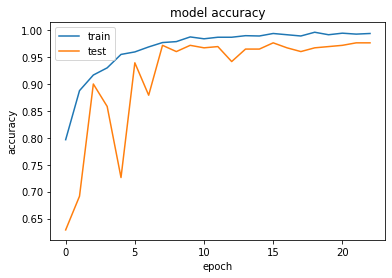

In [78]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

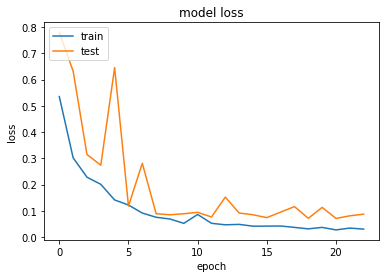

In [79]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")


# **Testing images from internet**


In [2]:

#importing the model
from tensorflow.keras.models import model_from_json 
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('model.h5')

In [ ]:
class_dict = train_generator.class_indices
class_list = list(class_dict.keys())
class_list

In [8]:
class_list=['early blight', 'healthy', 'late blight']

In [9]:
import cv2
def preprocess(image): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image , (256,256))
    # create a simple mask image th the original one
    mask = np.zeros(image.shape[:2], np.uint8) 

    # specify the background and foreground model 
    backgroundModel = np.zeros((1, 65), np.float64) 
    foregroundModel = np.zeros((1, 65), np.float64) 

    # define the Region of Interest (ROI) as the coordinates of the rectangle 
    rectangle = (20, 20, 220, 220) 
    cv2.grabCut(image, mask,rectangle,
                backgroundModel, foregroundModel,
                1,cv2.GC_INIT_WITH_RECT) 

    mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8')
    image = image * mask2[:, :, np.newaxis] 
    image = image/255
    return image

In [10]:
def predict_class(model,image_path):
  original_image = cv2.imread(image_path)
  image = preprocess(original_image)
  tab = []
  tab.append(image)
  tab = np.array(tab)
  h = np.expand_dims(tab, axis=2)
  h=model.predict(tab)
  predicted_class = np.argmax(h[0])
  confidence = np.max(h[0])

  # plot resutls 
  plt.figure(figsize = (4,4))
  plt.imshow(image)
  plt.axis('off')
  plt.title('prediction: '+class_list[predicted_class]+' with conf '+str(confidence))
  plt.show()

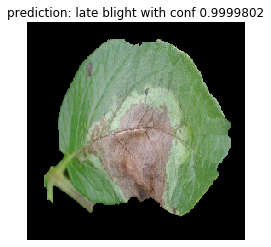

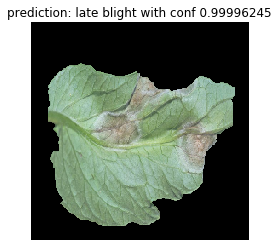

In [20]:
predict_class(loaded_model,'test/lateb.jpg')
predict_class(loaded_model,'test/lateb2.jpg')

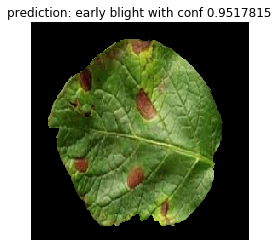

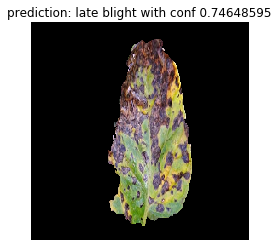

In [21]:
predict_class(loaded_model,'test/earlyb.jpg')
predict_class(loaded_model,'test/earlyb1.jpg')

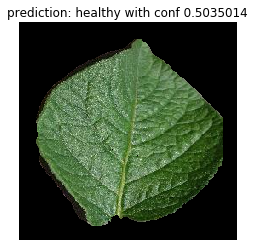

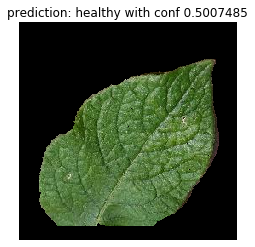

In [22]:
predict_class(loaded_model,'test/healthy.jpg')
predict_class(loaded_model,'test/healthy1.jpg')